## GMM - Gaussian Mixture Models

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fix the Random seed for Reproducibility
np.random.seed(40)

### Observations
1. The optimal number of clusters may vary based on the dataset and the clustering algorithm. It's essential to balance model complexity with model fit.
2. If BIC and AIC start to increase after a certain number of clusters, it indicates overfitting. Choosing a smaller number of clusters may be more appropriate in such cases.
3. The scatter plots can help visualize the clustering results. GMM may capture more complex relationships in the data, but the interpretation of clusters may be more challenging.
4. Silhouette scores provide a quantitative measure of clustering quality. Comparing silhouette scores between GMM and K-Means can help decide which algorithm is more suitable for the dataset.
5. The choice between GMM and K-Means depends on the specific goals of the analysis. GMM is more flexible but may require more data and more complex models, while K-Means is simpler and faster but assumes spherical clusters.

In [2]:
# Load the data from the customers dataset
customers = pd.read_csv('./SMAI-Dataset-customer-dataset/data.csv')
print(customers.head())

   Index  Gender  Marital status  Age  Education  Income  Occupation  \
0      0       0               0   67          2  124670           1   
1      1       1               1   22          1  150773           1   
2      2       0               0   49          1   89210           0   
3      3       0               0   45          1  171565           1   
4      4       0               0   53          1  149031           1   

   Settlement size  
0                2  
1                2  
2                0  
3                1  
4                1  


In [3]:
# Initialize a GMM Class
from scipy.stats import multivariate_normal

class GMM:
    # Define the init function
    def __init__(self, k=2, max_iter=1):
        self.k = k
        self.max_iter = max_iter

    def initalize_params(self, dataset):
        # Initialize the weights
        self.iterations = 0
        self.weights = np.ones(self.k) / self.k # Equal weights for each cluster
        # Initialize the means
        random_row = np.random.randint(low=0, high=dataset.shape[0], size=self.k)
        self.means = dataset[random_row, :]
        # For each mean, find the variance while iterating through the entire dataset
        self.variances = []
        for mean in self.means:
            self.variances.append(np.cov(dataset - mean, rowvar=False))
        self.variances = np.array(self.variances)
        self.responsibilities = []
        self.prev_likelihood = 0
        self.prev_responsibilities = []

    def multivariate_gaussian(self, dataset, mean, variance, datapoint):
        # Find the Determinant of the Variance matrix
        det = np.linalg.det(variance)
        # Find the inverse of the variance matrix
        inv = np.linalg.inv(variance)
        # Find the Denominator, first (2*pi)^(k/2) * det^(1/2)
        den = (2 * np.pi) ** (dataset.shape[1] / 2) * det ** (1 / 2)
        # Find the numerator inside the exp part
        exp = np.exp(-0.5*np.dot(np.dot((datapoint - mean), inv), (datapoint - mean).T))
        # Convert to scalar
        exp = exp[0][0]
        # Find the final probability
        prob = exp / den
        return prob

    def get_responsibilities(self, dataset): 
        # Find the Denominator of the responsibilities
        # The Final Responsibilities array must be a (n, k) array
        self.responsibilities = []
        for mean, variance, weight in zip(self.means, self.variances, self.weights):
            temp = []
            for datapoint in dataset:
                mean_expanded = np.expand_dims(mean, axis=0) # Mean is a 1*7 array
                numerator = weight * self.multivariate_gaussian(dataset, mean_expanded, variance, datapoint) # Numerator is a scalar
                temp.append(numerator) # Append the numerator to the temp array
            self.responsibilities.append(temp)

        self.responsibilities = np.array(self.responsibilities)
        # Take Transpose of the responsibilities array
        self.responsibilities = self.responsibilities.T

        # Normalize the responsibilities array
        for row in range(len(self.responsibilities)):
            self.responsibilities[row] = self.responsibilities[row]/np.sum(self.responsibilities[row])

        return

    def set_expectation(self, dataset):
        # For each row in the dataset, find out responsibility with respect to each cluster
        self.prev_responsibilities = self.responsibilities
        self.get_responsibilities(dataset)
        # Check if the sum of the responsibilities is 1

    def max_expectation(self, dataset):
        # Calculate new weights for each cluster
        self.weights = np.mean(self.responsibilities, axis=0)
        print(self.weights)
        # Calculate new means for each cluster
        self.means = np.dot(self.responsibilities.T, dataset) / np.sum(self.responsibilities, axis=0)[:, np.newaxis]
        # Calculate new variances for each cluster
        temp_variances = []
        for i in range(self.k):
            diff = dataset - self.means[i]
            weighted_diff = self.responsibilities[:, i][:, np.newaxis] * diff
            variance = np.dot(weighted_diff.T, diff) / np.sum(self.responsibilities[:, i])
            # Regularize the variance, with a diagonal matrix of 1e-4
            variance += 1e-4 * np.eye(dataset.shape[1])
            temp_variances.append(variance)
        self.variances = temp_variances

    def fit(self, dataset):
        # Loop through the expectation and maximization steps
        for i in range(self.max_iter):
            # Expectation step
            self.set_expectation(dataset)
            # Maximization step
            self.max_expectation(dataset)

    def fit_perfect(self, dataset):
        # Loop through the expectation and maximization steps
        while True:
            # Expectation step
            self.set_expectation(dataset)
            # Maximization step
            self.max_expectation(dataset)

            if self.iterations > 3:
                if np.allclose(self.responsibilities, self.prev_responsibilities):
                    break

            self.prev_responsibilities = self.responsibilities
            self.iterations += 1

    def return_params(self):
        return self.weights, self.means, self.variances
    
    def predict(self, dataset):
        # Find the responsibilities
        self.get_responsibilities(dataset)
        # Return the maximum responsibility for each datapoint
        return np.argmax(self.responsibilities, axis=1)
    def reset(self):
        self.iterations = 0

# Convert the pandas df to a numpy array
data = customers.values
data = np.array(data[:, 1:], dtype=float)

data_copy = data.copy()

# Initialize the GMM class
gmm = GMM(k=3, max_iter=100)
gmm.initalize_params(data)
gmm.fit_perfect(data)
weights, means, variances = gmm.return_params()
# print("Weights: ", weights)
# print("Means: ", means)
# print("Variances: ", variances)


[0.52801546 0.12739116 0.34459337]
[0.53966008 0.13338051 0.32695941]
[0.55195445 0.13783754 0.31020801]
[0.55646853 0.14003007 0.3035014 ]
[0.54254111 0.14054199 0.3169169 ]
[0.51049306 0.14144861 0.34805833]
[0.47595619 0.14933181 0.37471199]
[0.43376694 0.14606806 0.420165  ]
[0.36591148 0.12413457 0.50995395]
[0.35887253 0.10228943 0.53883803]
[0.3604964  0.09650378 0.54299982]
[0.35824966 0.09875034 0.543     ]
[0.35665579 0.10034421 0.543     ]
[0.35552752 0.10147248 0.543     ]
[0.35472982 0.10227018 0.543     ]
[0.35416201 0.10283799 0.543     ]
[0.35375433 0.10324567 0.543     ]
[0.3534594 0.1035406 0.543    ]
[0.35324476 0.10375524 0.543     ]
[0.35308784 0.10391216 0.543     ]
[0.35297274 0.10402726 0.543     ]
[0.35288811 0.10411189 0.543     ]
[0.35282576 0.10417424 0.543     ]
[0.35277977 0.10422023 0.543     ]
[0.35274581 0.10425419 0.543     ]
[0.35272072 0.10427928 0.543     ]
[0.35270217 0.10429783 0.543     ]
[0.35268845 0.10431155 0.543     ]
[0.35267829 0.10432171 

## Part - 2 : Wine Dataset

[0.64991748 0.24106885 0.10901367]
[0.64976192 0.23476667 0.11547141]
[0.6453353  0.23376123 0.12090348]
[0.64230572 0.23267163 0.12502265]
[0.64080446 0.23039378 0.12880176]
[0.64034311 0.22710701 0.13254988]
[0.64051641 0.22326049 0.1362231 ]
[0.64104432 0.21923346 0.13972222]
[0.64174079 0.2152706  0.14298861]
[0.6424795  0.21150849 0.14601201]
[0.64316831 0.20801753 0.14881416]
[0.64373333 0.20483466 0.15143201]
[0.64411002 0.20198328 0.1539067 ]
[0.64423825 0.19948394 0.15627781]
[0.64405918 0.19735989 0.15858093]
[0.64351316 0.19564015 0.16084669]
[0.64253843 0.19436123 0.16310034]
[0.64107114 0.19356756 0.1653613 ]
[0.6390469  0.19331038 0.16764272]
[0.6364044  0.19364467 0.16995093]
[0.63309092 0.19462417 0.17228491]
[0.62906913 0.19629487 0.17463599]
[0.62432374 0.19868835 0.1769879 ]
[0.61886599 0.2018164  0.17931762]
[0.61273441 0.20566855 0.18159703]
[0.60599126 0.21021322 0.18379552]
[0.59871541 0.21540164 0.18588296]
[0.59099386 0.22117353 0.18783261]
[0.58291392 0.227462

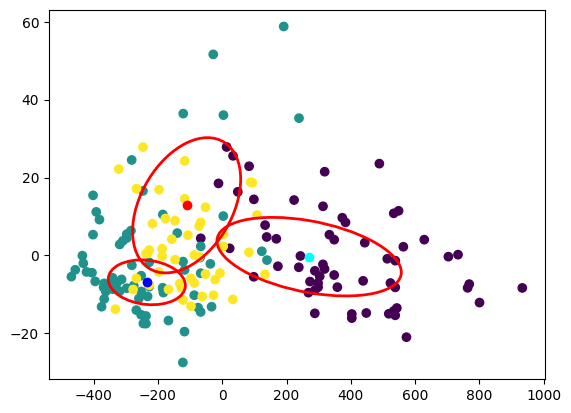

In [4]:
import sklearn.datasets as dt
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
dataset = dt.load_wine()
data = dataset.data
labels = dataset.target

# Perform PCA on the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# Initialize the GMM class
gmm = GMM(k=3, max_iter=1000)
gmm.initalize_params(data)
gmm.fit_perfect(data)
weights, means, variances = gmm.return_params()

# Plot the means, obtained from the gmm in the graph
plt.scatter(data[:, 0], data[:, 1], c=labels)
# Each Mean has a different colour
plt.scatter(means[0][0], means[0][1], c='red')
plt.scatter(means[1][0], means[1][1], c='blue')
plt.scatter(means[2][0], means[2][1], c='cyan')

# Visualize the variances, as ellipses -------------------------- # Chat GPT # --------------------------
from matplotlib.patches import Ellipse
for i in range(len(variances)):
    # Find the eigenvalues and eigenvectors of the variance matrix
    eigenvalues, eigenvectors = np.linalg.eig(variances[i])
    # Find the angle of rotation of the ellipse
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    # Find the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    # Plot the ellipse
    ellipse = Ellipse(xy=means[i], width=width, height=height, angle=angle, edgecolor='red', fc='None', lw=2)
    plt.gca().add_patch(ellipse)
# Visualize the variances, as ellipses -------------------------- # Chat GPT # --------------------------

plt.show()

# From the Data after PCA, make predictions for class
predictions = gmm.predict(data)



Data:  [[ 3.18562979e+02  2.14921307e+01]
 [ 3.03097420e+02 -5.36471768e+00]
 [ 4.38061133e+02 -6.53730945e+00]
 [ 7.33240139e+02  1.92729032e-01]
 [-1.15714285e+01  1.84899946e+01]
 [ 7.03231192e+02 -3.32158674e-01]
 [ 5.42971581e+02 -1.35189666e+01]
 [ 5.48401860e+02  1.14494324e+01]
 [ 2.98036863e+02 -8.18015784e+00]
 [ 2.98049553e+02 -7.10154294e+00]
 [ 7.63079712e+02 -8.33431723e+00]
 [ 5.32943228e+02 -1.42876338e+01]
 [ 5.72834410e+02 -2.10050143e+01]
 [ 4.02925358e+02 -1.61026352e+01]
 [ 8.00053394e+02 -1.21184472e+01]
 [ 5.63245578e+02  2.21482866e+00]
 [ 5.33379651e+02  1.08048022e+01]
 [ 3.83317591e+02  8.47741982e+00]
 [ 9.33118387e+02 -8.35447844e+00]
 [ 9.84031775e+01  1.43926594e+01]
 [ 3.35935940e+01  2.55679565e+01]
 [ 2.31464375e+01  1.81747309e+00]
 [ 2.88093030e+02 -3.96304175e+00]
 [ 2.67981513e+02 -9.57070401e+00]
 [ 9.80198858e+01 -5.49584606e+00]
 [ 8.34987440e+01  2.28916215e+01]
 [ 4.47925596e+02 -1.47973313e+01]
 [ 5.37919165e+02 -1.53883461e+01]
 [ 1.68210468

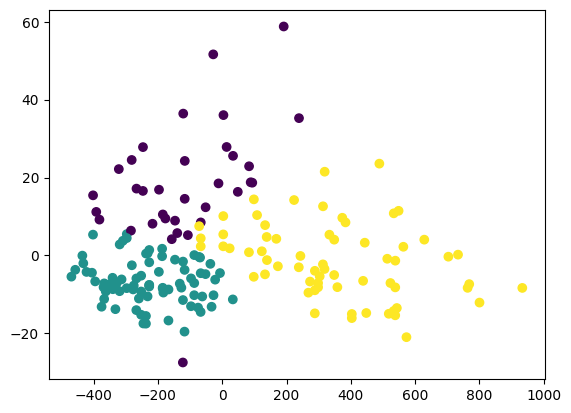

In [9]:
# Data After Clustering

# Print the Data
print("Data: ", data)
# Plot the Data
plt.scatter(data[:, 0], data[:, 1], c=predictions)

## AIC and BIC Scores

[1.]
[1.]
[1.]
[1.]
[1.]
[0.48701048 0.51298952]
[0.50025231 0.49974769]
[0.50228088 0.49771912]
[0.4996077 0.5003923]
[0.4972983 0.5027017]
[0.49632264 0.50367736]
[0.49636252 0.50363748]
[0.49697398 0.50302602]
[0.49783851 0.50216149]
[0.49877814 0.50122186]
[0.49970314 0.50029686]
[0.50057161 0.49942839]
[0.50136663 0.49863337]
[0.50208409 0.49791591]
[0.50272619 0.49727381]
[0.50329805 0.49670195]
[0.50380587 0.49619413]
[0.50425604 0.49574396]
[0.50465471 0.49534529]
[0.50500756 0.49499244]
[0.50531973 0.49468027]
[0.50559587 0.49440413]
[0.50584011 0.49415989]
[0.50605611 0.49394389]
[0.50624714 0.49375286]
[0.50641607 0.49358393]
[0.50656547 0.49343453]
[0.50669759 0.49330241]
[0.50681444 0.49318556]
[0.50691777 0.49308223]
[0.50700915 0.49299085]
[0.50708997 0.49291003]
[0.50716144 0.49283856]
[0.50722465 0.49277535]
[0.50728055 0.49271945]
[0.50732999 0.49267001]
[0.50737371 0.49262629]
[0.50741237 0.49258763]
[0.50744657 0.49255343]
[0.50747681 0.49252319]
[0.50750356 0.49249

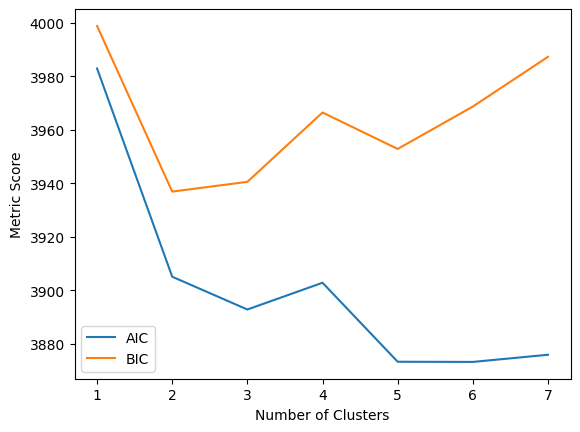

[0.45998156911954846, 0.20092605456716744, 0.13930220997973916, 0.16500151835961316, 0.14759974278165028, 0.07927115131317977]


In [5]:
from scipy.stats import multivariate_normal

AIC = []
BIC = []
silhouette_arr = []

# Assuming you have the labels for each data point after clustering

# Fit the Model, and find the Likelihood
for k in range(1, 8):
    gmm = GMM(k=k, max_iter=100)  # Initialize GMM with k components
    gmm.initalize_params(data)
    gmm.fit_perfect(data)
    weights, means, variances = gmm.return_params()

    # Find the Likelihood of the model
    likelihood = 0
    for i in range(len(data)):
        temp = 0
        for j in range(k):  # Sum over all components
            temp += weights[j] * multivariate_normal.pdf(data[i], mean=means[j], cov=variances[j])
        likelihood += np.log(temp)

    # Calculate the number of parameters in the model
    # For GMM, this includes the number of means, variances, and weights
    num_params = k * (2 * data.shape[1] + 1)  # means + variances + weights

    # Calculate AIC and BIC
    aic = -2 * likelihood + 2 * num_params
    bic = -2 * likelihood + num_params * np.log(len(data))

    cluster_labels = gmm.predict(data)  # You might need to implement this method in your GMM class

    if k > 1:
        # Calculate Silhouette Score
        silhouette = metrics.silhouette_score(data, cluster_labels)
        silhouette_arr.append(silhouette)

    AIC.append(aic)
    BIC.append(bic)

# Plot the AIC and BIC
plt.plot(range(1, 8), AIC, label='AIC')
plt.plot(range(1, 8), BIC, label='BIC')

plt.xlabel('Number of Clusters')
plt.ylabel('Metric Score')
plt.legend()
plt.show()

print(silhouette_arr)